# IQ Multi Target Detection In Heavy Tailed Clutter Using Diffusion

## Imports

In [2]:
import os
import math
import torch
import wandb
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, ConcatDataset

### wandb

In [3]:
# os.environ["#wandb_NOTEBOOK_NAME"] = "compare.ipynb"
# #wandb.login(key="a0b9279da3b2e8d45e371d1539a1118e7b82d303")
# #wandb.init(project="Diffusion-for-radar", mode="online")

## dataset

In [4]:
class RadarDataset(Dataset):
    def __init__(self, num_samples, n_targets, random_n_targets, nu=None, scnr=None, snr=None, cnr=None):
        super().__init__()
        self.num_samples = num_samples
        self.n_targets = n_targets
        self.random_n_targets = random_n_targets
        self.with_targets = n_targets > 0
        self.snr_dB = snr
        self.cnr_dB = cnr
        self.scnr = scnr
        self.nu = torch.tensor([nu], dtype=torch.float) if nu is not None else None

        # Radar parameters
        self.N = 64       # fast–time samples per pulse
        self.K = 64       # slow–time pulses per frame
        self.B = 50e6     # Chirp bandwidth (Hz)
        self.T0 = 1e-3    # PRI (s)
        self.fc = 9.39e9  # Carrier frequency (Hz)
        self.c = 3e8      # Speed of light (m/s)
        self.CNR = 15     # in dB (only used if snr/cnr are NOT given)

        # Range and Doppler settings
        self.r_min, self.r_max = 0, 189    # meters
        self.v_min, self.v_max = -7.8, 7.8   # m/s (for targets)
        self.vc_min, self.vc_max = -7.8, 7.8 # m/s (for clutter)
        self.dr = 3       # Range resolution in m
        self.dv = 0.249   # Doppler resolution in m/s

        # Range and Doppler bins (for label maps)
        self.R = torch.arange(self.r_min, self.r_max + self.dr, self.dr)
        self.V = torch.arange(self.v_min, self.v_max + self.dv, self.dv)
        self.dR = len(self.R)
        self.dV = len(self.V)

        # Noise power calculation (only used if snr/cnr not specified)
        self.sigma2 = self.N / (2 * 10 ** (self.CNR / 10))
        
        # For old scnr logic, we also computed a "normalization" factor
        self.cn_norm = torch.sqrt(
            torch.tensor(
                self.N * self.K * (self.N // 2 + self.sigma2), dtype=torch.float
            )
        )

    def generate_target_signal(self, ranges, velocities, phases, gains_dB):
        """
        Creates the raw (unscaled) target signals for each target,
        then (if old scnr approach) scales them to achieve the desired scnr in dB,
        or returns them raw for later scaling if snr/cnr approach is used.
        """
        # Range steering vector (one per target)
        w_r = (2 * torch.pi * 2 * self.B * ranges) / (self.c * self.N)
        range_steering = torch.exp(-1j * torch.outer(w_r, torch.arange(self.N, dtype=torch.float)))
        
        # Doppler steering vector (one per target)
        w_d = (2 * torch.pi * self.T0 * 2 * self.fc * velocities) / self.c
        doppler_steering = torch.exp(-1j * torch.outer(w_d, torch.arange(self.K, dtype=torch.float)))
        
        # Form the fast–time × slow–time target signature for each target
        rd_signal = range_steering.unsqueeze(-1) * doppler_steering.unsqueeze(1)
        rd_signal = rd_signal * torch.exp(1j * phases)  # impart random phase per target
        
        # If we are using the old SCNR approach, scale immediately
        # Gains in dB => each target’s SCNR
        if (self.snr_dB is None) or (self.cnr_dB is None):
            # Old approach: sum all scaled targets into a single matrix
            S_norm = torch.linalg.norm(rd_signal, dim=(1, 2)).real
            sig_amp = (10 ** (gains_dB / 20)) * (self.cn_norm / S_norm)
            rd_signal = (sig_amp.unsqueeze(-1).unsqueeze(-1) * rd_signal).sum(dim=0)
            return rd_signal
        else:
            # With the new approach, we do NOT scale by SCNR here.
            # We return the raw sum across all targets, for later power-based scaling.
            rd_signal = rd_signal.sum(dim=0)
            return rd_signal

    def generate_clutter(self, nu):
        # Choose a clutter velocity uniformly within the allowed limits
        clutter_vel = torch.empty(1).uniform_(self.vc_min, self.vc_max)
        fd = 2 * torch.pi * (2 * self.fc * clutter_vel) / self.c 
        sigma_f = 0.05  # Correlation parameter (from the referenced paper)

        p, q = torch.meshgrid(
            torch.arange(self.N, dtype=torch.float),
            torch.arange(self.K, dtype=torch.float),
            indexing='ij'
        )
        # M is the covariance-like matrix for correlated clutter
        M = torch.exp(
            -2 * torch.pi**2 * sigma_f**2 * (p - q)**2
            - 1j * (p - q) * fd * self.T0
        )

        # Draw complex Gaussian
        z = torch.randn(self.K, self.dR, dtype=torch.cfloat) / torch.sqrt(torch.tensor(2.0))
        e, V_mat = torch.linalg.eigh(M)  # eigen-decomposition
        e_sqrt = torch.sqrt(torch.clamp(e.real, min=0.0))
        E = torch.diag(e_sqrt)
        A = V_mat @ E.to(V_mat.dtype)
        w_t = A @ z  # shaping the random draws to match M

        # Impart heavy–tailed behavior via Gamma modulation (shape = scale = nu)
        s = torch.distributions.Gamma(nu, nu).sample((self.dR,))
        c_t = (torch.sqrt(s).unsqueeze(0) * w_t.unsqueeze(-1)).squeeze(-1)

        # Convert to fast–time × slow–time representation
        # using a range–steering operation.
        c_r_steer = torch.exp(
            -1j 
            * 2 
            * torch.pi 
            * torch.outer(torch.arange(self.N, dtype=torch.float), self.R)
            * (2 * self.B) / (self.c * self.N)
        )
        C = c_r_steer @ c_t.transpose(0, 1)
        return C

    def gen_frame_and_labels(self):
        """
        Generate one radar data frame, label map, and the separate S, C, W
        so that we can control SNR and CNR (if specified).
        """
        # 1. Generate unscaled noise (mean 0, unit variance in each real/imag component).
        #    We'll measure it and scale later if snr/cnr is used.
        W_unscaled = torch.randn(self.N, self.K, dtype=torch.cfloat) / torch.sqrt(torch.tensor(2.0))
        
        # 2. Generate unscaled clutter
        nu = torch.empty(1).uniform_(0.1, 1.5) if self.nu is None else self.nu
        C_unscaled = self.generate_clutter(nu)
        
        # 3. Prepare to generate target signal(s)
        #    We'll choose random targets if with_targets == True
        S_unscaled = torch.zeros(self.N, self.K, dtype=torch.cfloat)
        rd_label = torch.zeros(self.dR, self.dV)

        if self.with_targets:
            n = (
                torch.randint(1, self.n_targets + 1, (1,)).item()
                if self.random_n_targets
                else self.n_targets
            )
            ranges = torch.empty(n).uniform_(self.r_min, self.r_max)
            velocities = torch.empty(n).uniform_(self.v_min, self.v_max)
            phases = torch.empty(n, 1, 1).uniform_(0, 2 * torch.pi)
            
            # If new SNR/CNR approach is NOT used, we fallback to scnr or [-5, 10] dB random
            if (self.snr_dB is None) or (self.cnr_dB is None):
                SCNR_dBs = torch.empty(n).uniform_(-5, 10) if self.scnr is None else self.scnr * torch.ones(n)
                S_unscaled = self.generate_target_signal(ranges, velocities, phases, SCNR_dBs)
            else:
                # Just pass dummy dB array here; we won't scale inside 'generate_target_signal'
                # Instead, we will do the scaling outside
                S_raw = []
                for i in range(n):
                    # Each target can have the same 'gain' placeholder
                    s_i = self.generate_target_signal(
                        ranges[i].unsqueeze(-1),
                        velocities[i].unsqueeze(-1),
                        phases[i].unsqueeze(-1),
                        gains_dB=torch.tensor([0.0])  # placeholder
                    )
                    S_raw.append(s_i)
                # Sum all targets
                S_unscaled = sum(S_raw)

            # For each target, mark the closest range and Doppler bin.
            for r, v in zip(ranges, velocities):
                r_bin = torch.argmin(torch.abs(self.R - r))
                v_bin = torch.argmin(torch.abs(self.V - v))
                rd_label[r_bin, v_bin] = 1

        # ---------------------------
        # NEW: If snr & cnr are given, do amplitude scaling here
        # ---------------------------
        if (self.snr_dB is not None) and (self.cnr_dB is not None):
            # 1) measure raw powers
            noise_power  = W_unscaled.abs().pow(2).mean()
            clutter_power= C_unscaled.abs().pow(2).mean() if C_unscaled.numel() > 0 else 0.0
            signal_power = S_unscaled.abs().pow(2).mean() if S_unscaled.numel() > 0 else 0.0

            # 2) define desired linear ratios
            snr_lin = 10 ** (self.snr_dB / 10)
            cnr_lin = 10 ** (self.cnr_dB / 10)

            # 3) define desired final powers
            #    We'll anchor the noise to "1.0" average power for convenience
            #    (or you could anchor it to some other power). Then scale clutter & signal.
            #    Step (A): Scale noise to final_noise_power = 1.0
            #             => alpha_n = sqrt(1 / noise_power).
            alpha_n = torch.sqrt(1.0 / noise_power)
            W = alpha_n * W_unscaled  # final noise
            final_noise_power = W.abs().pow(2).mean()

            #    Step (B): Clutter should have average power = cnr_lin * final_noise_power
            if clutter_power > 0:
                alpha_c = torch.sqrt((cnr_lin * final_noise_power) / clutter_power)
                C = alpha_c * C_unscaled
            else:
                C = torch.zeros_like(C_unscaled)

            #    Step (C): Signal should have average power = snr_lin * final_noise_power
            if signal_power > 0:
                alpha_s = torch.sqrt((snr_lin * final_noise_power) / signal_power)
                S = alpha_s * S_unscaled
            else:
                S = torch.zeros_like(S_unscaled)

        else:
            W = (W_unscaled / torch.sqrt(torch.tensor(self.sigma2)))  # old approach
            C = C_unscaled
            S = S_unscaled

        X = S + C + W
        
        # Optional: measure the resulting SCNR for *your own* info
        signal_energy  = S.abs().pow(2).sum()
        clutter_energy = C.abs().pow(2).sum()
        noise_energy   = W.abs().pow(2).sum()
        scnr_lin = signal_energy / (clutter_energy + noise_energy + 1e-12)
        scnr_dB  = 10.0 * torch.log10(scnr_lin + 1e-12)

        return S, C, W, X, rd_label, scnr_dB

    def __len__(self) -> int:
        return self.num_samples

    def __getitem__(self, idx: int):
        """
        Return the data and label for sample 'idx'.
        """
        signal, clutter, gaus_noise, IQ, rd_label, scnr_dB = self.gen_frame_and_labels()
        return signal, clutter, gaus_noise, IQ, rd_label, scnr_dB

In [5]:
def visualize_sample(dataset, sample_index: int = 0):

    signal, clutter, gaus_noise, IQ, rd_label, scnr_dB = dataset[sample_index]
    print(scnr_dB)
    plt.figure(figsize=(20, 6))
    plt.subplot(1, 6, 1)
    plt.imshow(torch.real(signal), aspect='auto', cmap='viridis')
    plt.title("Real clean Signal", fontsize=14)
    plt.xlabel("Fast Time", fontsize=12)
    plt.ylabel("Slow Time", fontsize=12)

    plt.subplot(1, 6, 2)
    plt.imshow(torch.imag(signal), aspect='auto', cmap='viridis')
    plt.title("Imaginary clean Siganl", fontsize=14)
    plt.xlabel("Fast Time", fontsize=12)
    plt.ylabel("Slow Time", fontsize=12)

    plt.subplot(1, 6, 3)
    plt.imshow(torch.real(clutter), aspect='auto', cmap='viridis')
    plt.title("Real Clutter", fontsize=14)
    plt.xlabel("Fast Time", fontsize=12)
    plt.ylabel("Slow Time", fontsize=12)

    plt.subplot(1, 6, 4)
    plt.imshow(torch.imag(clutter), aspect='auto', cmap='viridis')
    plt.title("Imaginary Clutter", fontsize=14)
    plt.xlabel("Fast Time", fontsize=12)
    plt.ylabel("Slow Time", fontsize=12)

    plt.subplot(1, 6, 5)
    plt.imshow(torch.real(gaus_noise), aspect='auto', cmap='viridis')
    plt.title("real white gaussian noise", fontsize=14)
    plt.xlabel("Fast Time", fontsize=12)
    plt.ylabel("Slow Time", fontsize=12)

    plt.subplot(1, 6, 6)
    plt.imshow(torch.imag(gaus_noise), aspect='auto', cmap='viridis')
    plt.title("Imaginary white gaussian noise", fontsize=14)
    plt.xlabel("Fast Time", fontsize=12)
    plt.ylabel("Slow Time", fontsize=12)

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(20, 6))
    plt.subplot(1,3,1)
    plt.imshow(abs(IQ), aspect='auto', cmap='viridis')
    plt.title("Noisy IQ Map", fontsize=14)
    plt.xlabel("Range", fontsize=12)
    plt.ylabel("Doppler", fontsize=12)

    plt.subplot(1,3,2)
    plt.imshow(abs(signal), aspect='auto', cmap='viridis')
    plt.title("Clean IQ Map", fontsize=14)
    plt.xlabel("Range", fontsize=12)
    plt.ylabel("Doppler", fontsize=12)

    plt.subplot(1,3,3)
    plt.imshow(rd_label, aspect='auto', cmap='viridis')
    plt.title("Ground Truth Label", fontsize=14)
    plt.xlabel("Range", fontsize=12)
    plt.ylabel("Doppler", fontsize=12)

    plt.tight_layout()
    plt.show()


In [6]:
def compare_nu_scnr(nu_values, scnr_values, radar_dataset_class):

    fig, axs = plt.subplots(
        nrows=len(nu_values),
        ncols=len(scnr_values) + 1,
        figsize=(20, 10),
        sharex=False,
        sharey=False
    )

    clutter_real_dict = {nu_val: [] for nu_val in nu_values}

    for i, nu_val in enumerate(nu_values):
        for j, scnr_val in enumerate(scnr_values):

            dataset = radar_dataset_class(
                num_samples=1,
                n_targets=1,          
                random_n_targets=False,
                nu=nu_val,            
                scnr=scnr_val         
            )
            
            signal, clutter, gaus_noise, IQ, rd_label, scnr_dB = dataset[0]

            iq_magnitude = torch.abs(IQ)
            iq_db = 20 * torch.log10(iq_magnitude + 1e-8)
            ax_rd = axs[i, j]
            im = ax_rd.imshow(iq_db, aspect='auto', cmap='viridis')
            ax_rd.set_title(f"nu={nu_val}, SCNR={scnr_val} dB", fontsize=9)
            plt.colorbar(im, ax=ax_rd)

        ax_hist = axs[i, -1]

        num_clutter_samples = 50
        real_values = []

        for _ in range(num_clutter_samples):
            dataset_clutter = radar_dataset_class(
                num_samples=1,
                n_targets=0,  
                random_n_targets=False,
                nu=nu_val
            )
            
            _, C_sample, W_sample, _, _, _ = dataset_clutter.gen_frame_and_labels()
            real_part = torch.real(C_sample).view(-1).cpu().numpy()
            real_values.extend(real_part)

        ax_hist.hist(real_values, bins=50, density=True, alpha=0.7, color='gray')
        ax_hist.set_title(f"Real(Clutter) Dist\n(nu={nu_val})", fontsize=9)
        ax_hist.set_xlabel("Amplitude (Real Part)")
        ax_hist.set_ylabel("PDF")

        clutter_real_dict[nu_val].extend(real_values)

    plt.tight_layout()
    plt.show()

    # -----------------------------------------------------
    # 2) Now plot a SECOND figure comparing all nu's at once
    # -----------------------------------------------------
    plt.figure(figsize=(8, 6))

    all_vals = []
    for nu_val in nu_values:
        all_vals.extend(clutter_real_dict[nu_val])
    min_val = min(all_vals)
    max_val = max(all_vals)
    bins = np.linspace(min_val, max_val, 100)

    for nu_val in nu_values:
        arr = clutter_real_dict[nu_val]
        plt.hist(arr, bins=bins, alpha=0.5, density=True, label=f"nu={nu_val}")

    plt.yscale('log')
    plt.xlabel("Real(Clutter) amplitude")
    plt.ylabel("PDF (log scale)")
    plt.title("Comparison of Clutter Real-Part Distributions for Different nu")
    plt.legend()
    plt.show()


tensor(-5.4075)


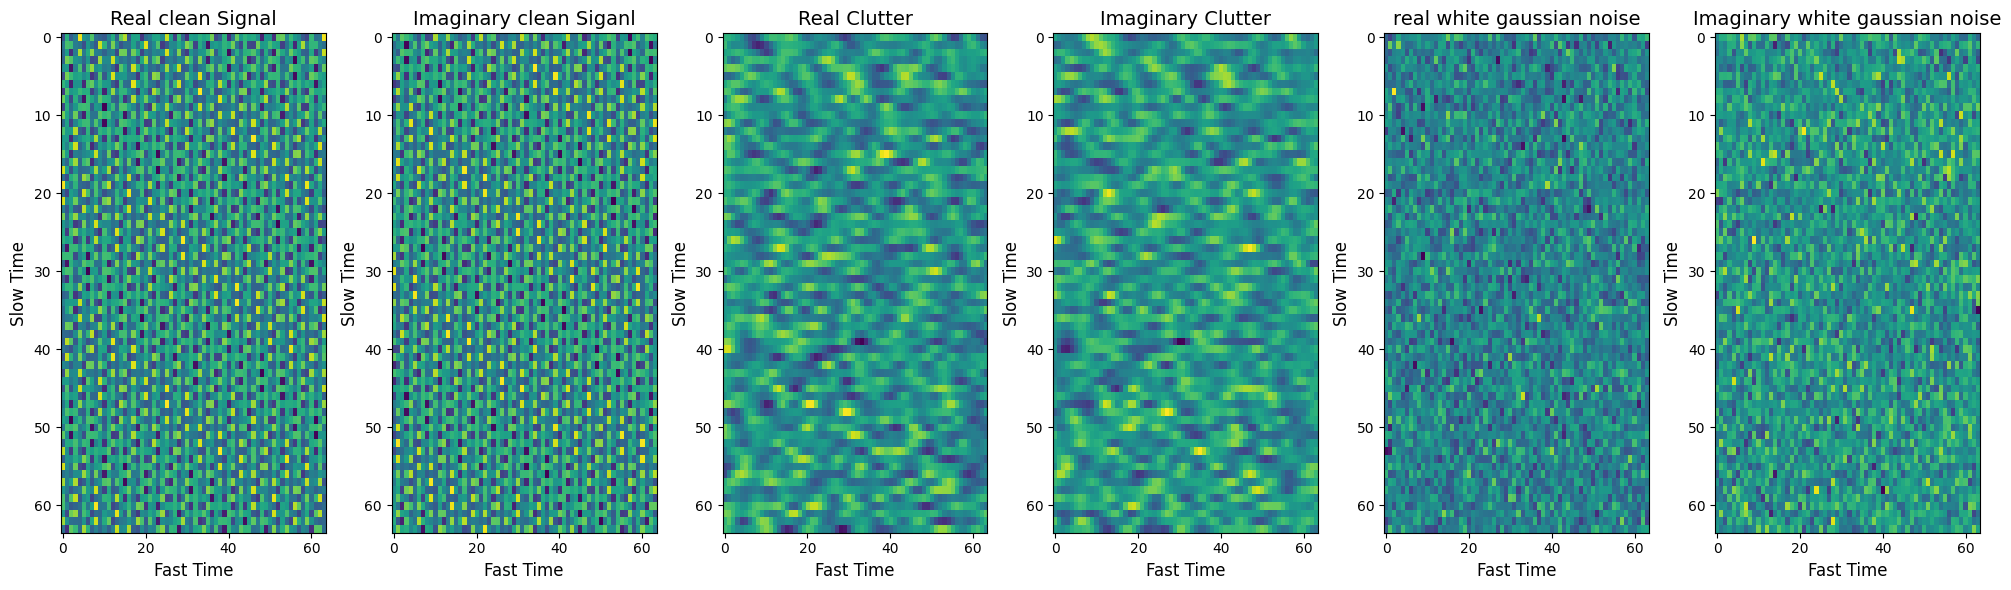

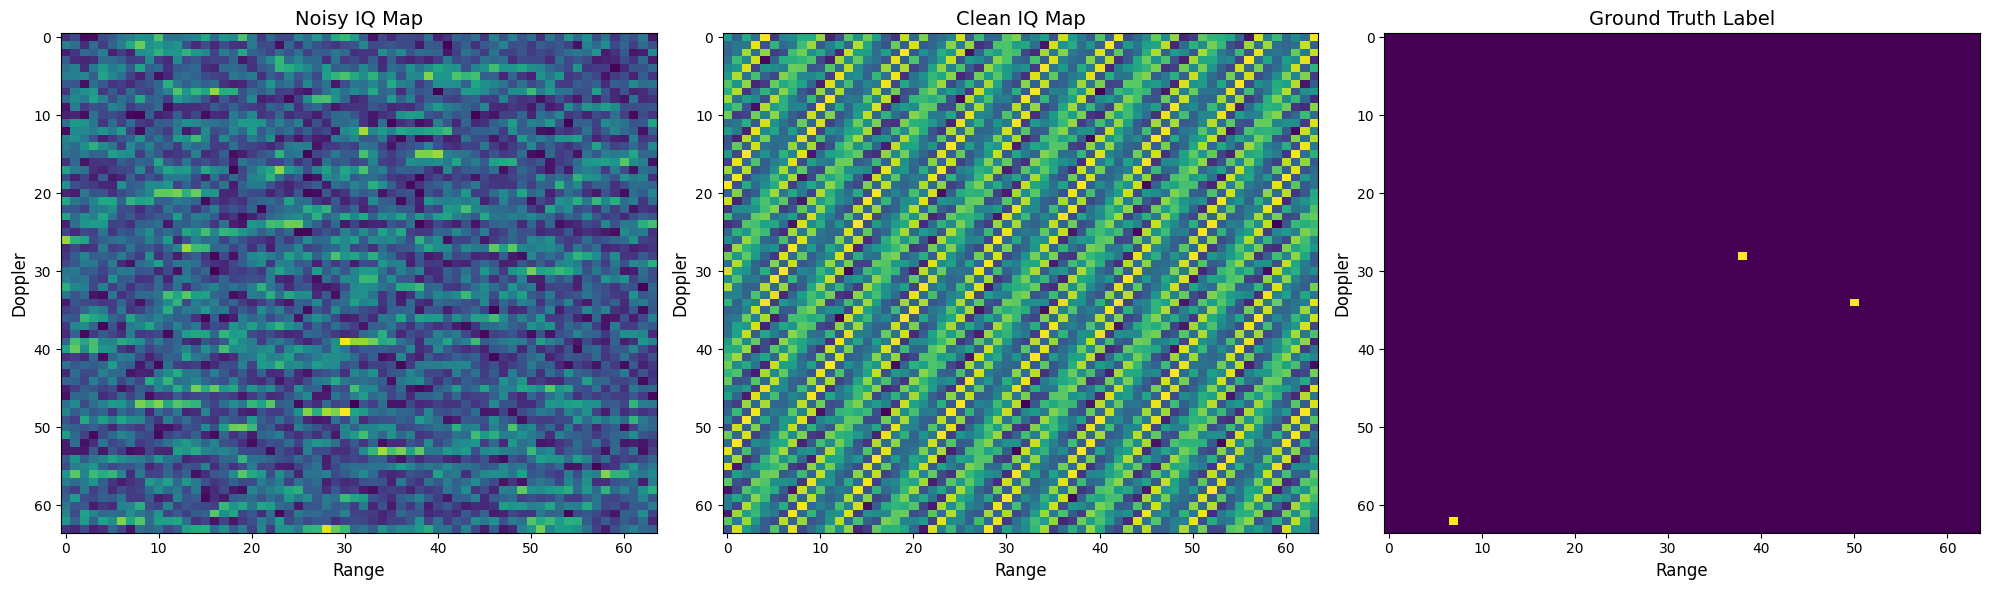

In [7]:
train_dataset_with_targets = RadarDataset(num_samples=10240, n_targets=8, random_n_targets=True, scnr=-10)
visualize_sample(train_dataset_with_targets, sample_index=1)

tensor(9.5861)


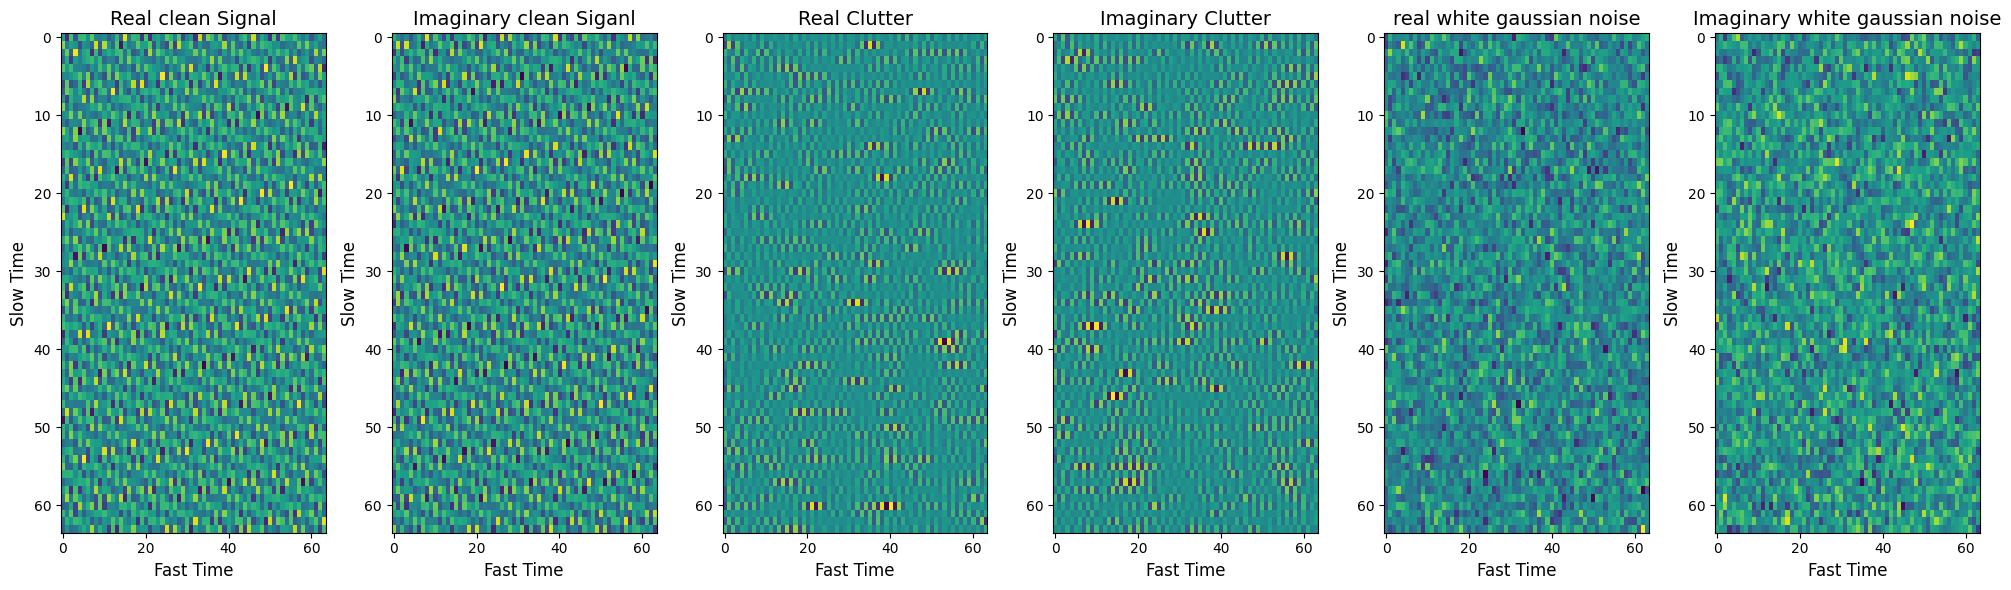

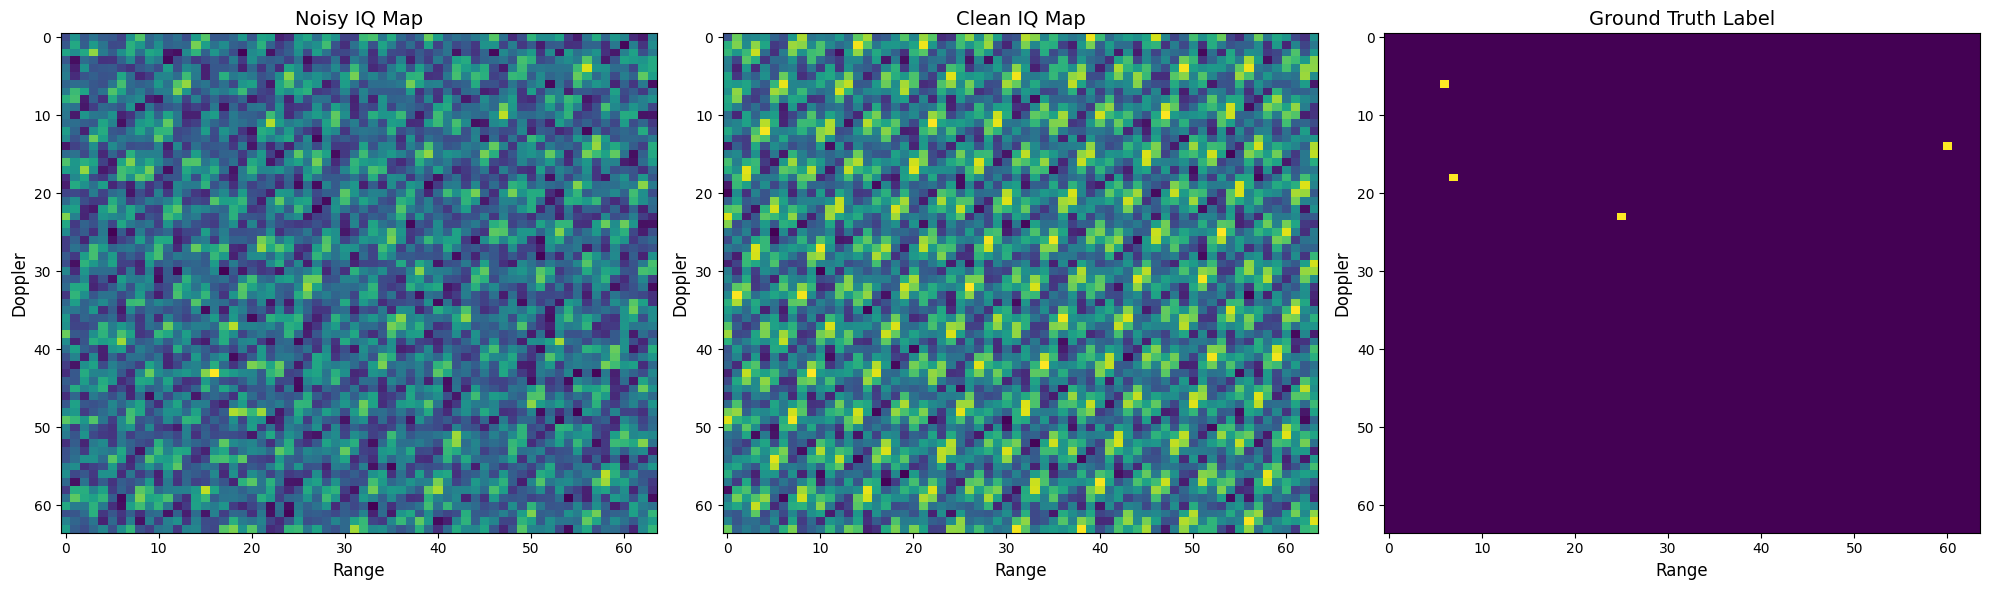

In [8]:
train_dataset_with_targets = RadarDataset(num_samples=10240, n_targets=4, random_n_targets=False, snr=20, cnr=10)
visualize_sample(train_dataset_with_targets, sample_index=1)

In [9]:
def compare_nu_scnr(nu_values, scnr_values, radar_dataset_class):

    fig, axs = plt.subplots(
        nrows=len(nu_values),
        ncols=len(scnr_values) + 1,
        figsize=(20, 10),
        sharex=False,
        sharey=False
    )

    clutter_real_dict = {nu_val: [] for nu_val in nu_values}

    for i, nu_val in enumerate(nu_values):
        for j, scnr_val in enumerate(scnr_values):

            dataset = radar_dataset_class(
                num_samples=1,
                n_targets=3,          
                random_n_targets=False,
                nu=nu_val,            
                scnr=scnr_val         
            )

            signal, clutter, gaus_noise, IQ, rd_label, scnr_dB = dataset[0]

            rd_magnitude = torch.abs(IQ)
            rd_db = 20 * torch.log10(rd_magnitude + 1e-8)
            ax_rd = axs[i, j]
            im = ax_rd.imshow(rd_db, aspect='auto', cmap='viridis')
            ax_rd.set_title(f"nu={nu_val}, SCNR={scnr_val} dB", fontsize=9)
            plt.colorbar(im, ax=ax_rd)

        ax_hist = axs[i, -1]

        num_clutter_samples = 50
        real_values = []

        for _ in range(num_clutter_samples):
            dataset_clutter = radar_dataset_class(
                num_samples=1,
                n_targets=0,  
                random_n_targets=False,
                nu=nu_val
            )
            _, C_sample, W_sample, _,_,_ = dataset_clutter.gen_frame_and_labels()
            real_part = torch.real(C_sample).view(-1).cpu().numpy()
            real_values.extend(real_part)

        ax_hist.hist(real_values, bins=50, density=True, alpha=0.7, color='gray')
        ax_hist.set_title(f"Real(Clutter) Dist\n(nu={nu_val})", fontsize=9)
        ax_hist.set_xlabel("Amplitude (Real Part)")
        ax_hist.set_ylabel("PDF")

        clutter_real_dict[nu_val].extend(real_values)

    plt.tight_layout()
    plt.show()

    # -----------------------------------------------------
    # 2) Now plot a SECOND figure comparing all nu's at once
    # -----------------------------------------------------
    plt.figure(figsize=(8, 6))

    all_vals = []
    for nu_val in nu_values:
        all_vals.extend(clutter_real_dict[nu_val])
    min_val = min(all_vals)
    max_val = max(all_vals)
    bins = np.linspace(min_val, max_val, 100)

    for nu_val in nu_values:
        arr = clutter_real_dict[nu_val]
        plt.hist(arr, bins=bins, alpha=0.5, density=True, label=f"nu={nu_val}")

    plt.yscale('log')
    plt.xlabel("Real(Clutter) amplitude")
    plt.ylabel("PDF (log scale)")
    plt.title("Comparison of Clutter Real-Part Distributions for Different nu")
    plt.legend()
    plt.show()


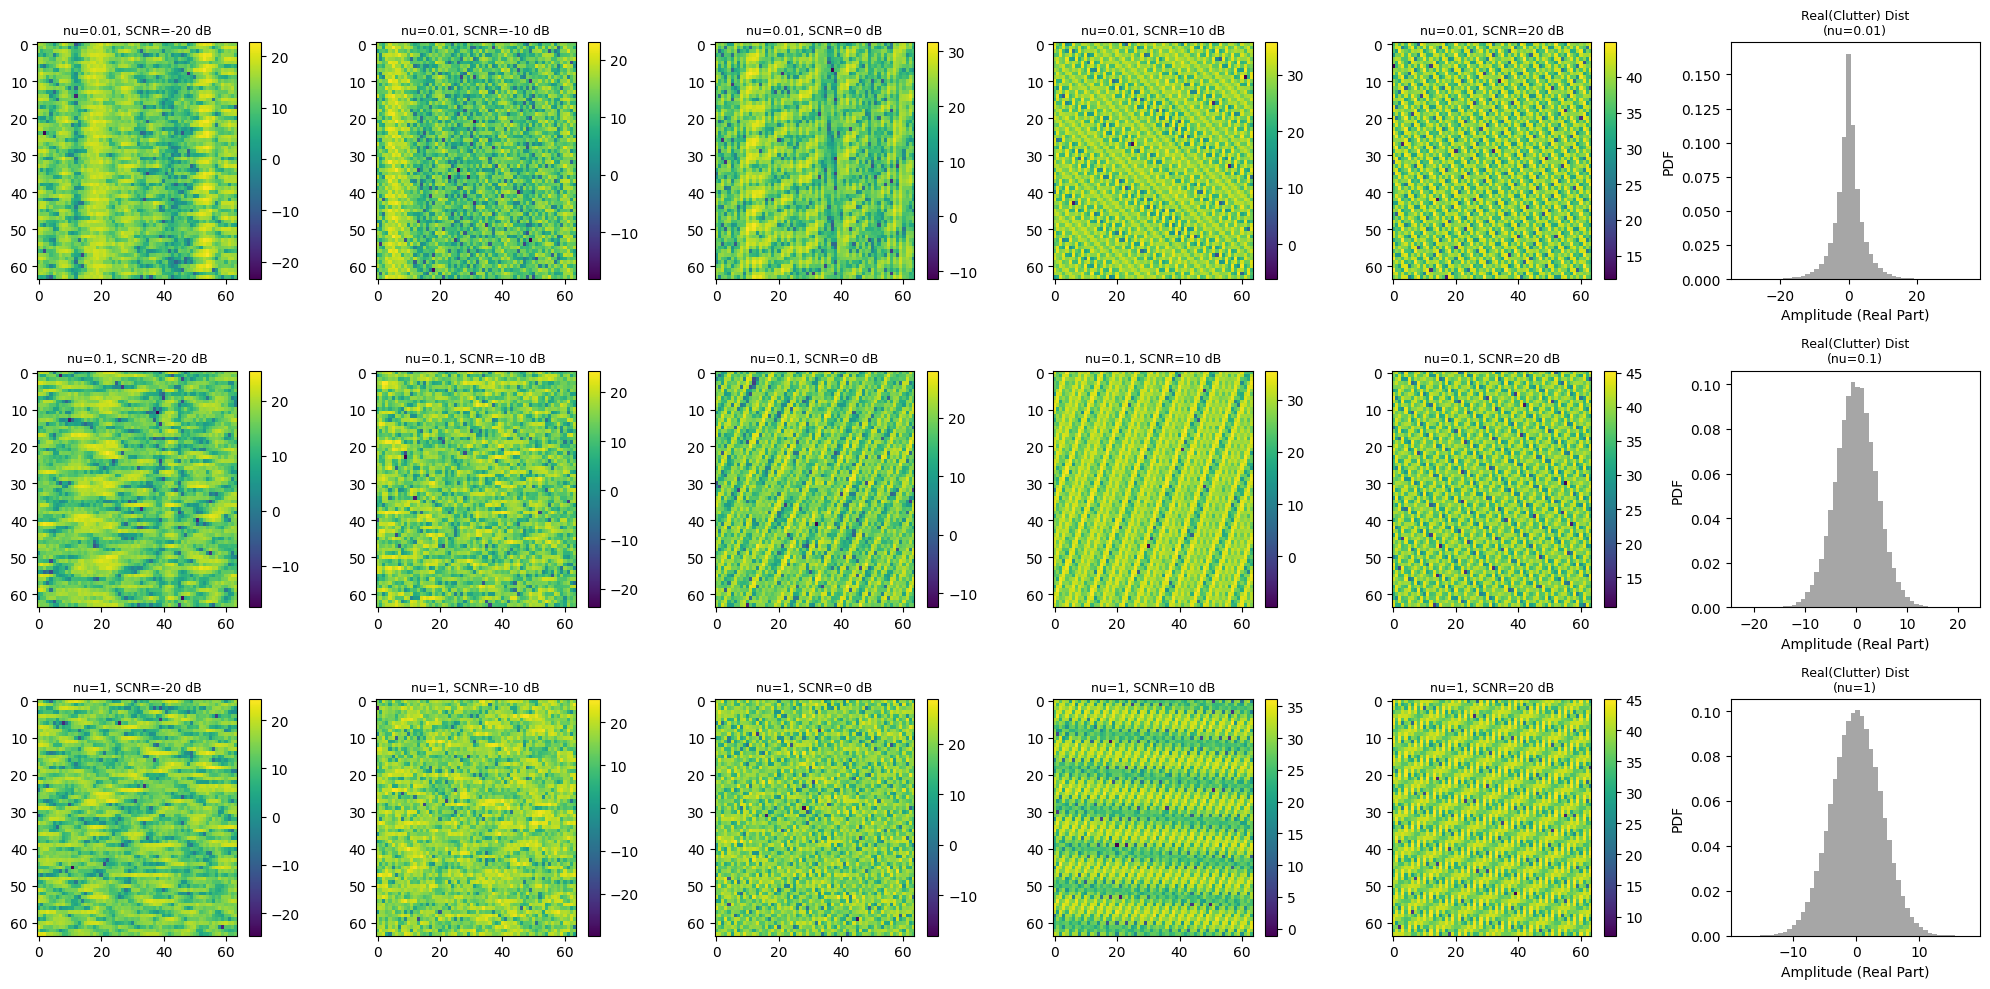

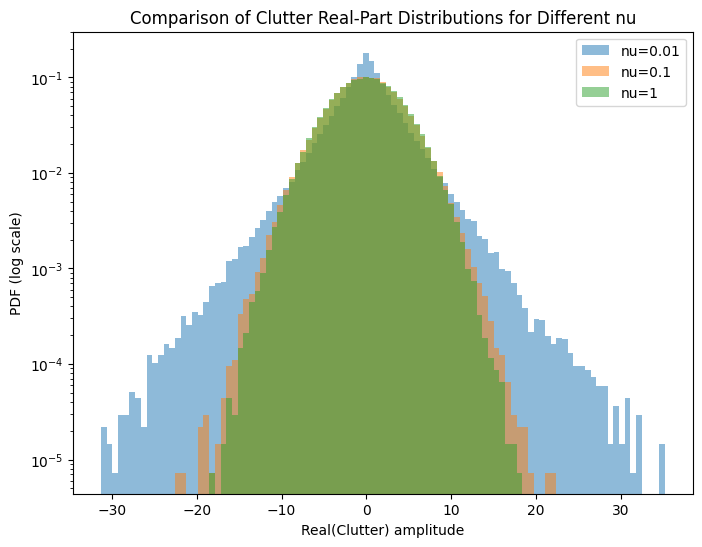

In [10]:
compare_nu_scnr(nu_values=[0.01, 0.1, 1], scnr_values=[-20, -10, 0, 10, 20], radar_dataset_class=RadarDataset)

## CFAR functions

In [11]:
def ca_cfar_2d(signal, num_train, num_guard, Pfa):
    """
    Standard CA–CFAR on a 2D signal.
    """
    rows, cols = signal.shape
    detection_map = np.zeros_like(signal)
    
    win_size = 2 * (num_train + num_guard) + 1
    guard_size = 2 * num_guard + 1
    num_training_cells = win_size**2 - guard_size**2
    
    # Scaling factor for exponential noise
    alpha = num_training_cells * (Pfa**(-1/num_training_cells) - 1)
    
    pad = num_train + num_guard
    padded_signal = np.pad(signal, pad, mode='constant', constant_values=0)
    
    for i in range(pad, pad + rows):
        for j in range(pad, pad + cols):
            window = padded_signal[i - pad:i + pad + 1, j - pad:j + pad + 1]
            start = num_train
            end = num_train + 2 * num_guard + 1
            training_cells = np.concatenate((window[:start, :].ravel(),
                                             window[end:, :].ravel(),
                                             window[start:end, :start].ravel(),
                                             window[start:end, end:].ravel()))
            noise_level = np.mean(training_cells)
            threshold = alpha * noise_level
            if signal[i - pad, j - pad] > threshold:
                detection_map[i - pad, j - pad] = 1
    return detection_map

def tm_cfar_2d(signal, num_train, num_guard, trim_ratio, Pfa):
    """
    TM–CFAR on a 2D signal.
    """
    rows, cols = signal.shape
    detection_map = np.zeros_like(signal)
    
    win_size = 2 * (num_train + num_guard) + 1
    guard_size = 2 * num_guard + 1
    num_training_cells = win_size**2 - guard_size**2
    
    # Number of cells to trim from each end
    trim_cells = int(trim_ratio * num_training_cells)
    effective_cells = num_training_cells - 2 * trim_cells
    if effective_cells <= 0:
        effective_cells = num_training_cells  # fallback
    alpha = effective_cells * (Pfa**(-1/effective_cells) - 1)
    
    pad = num_train + num_guard
    padded_signal = np.pad(signal, pad, mode='constant', constant_values=0)
    
    for i in range(pad, pad + rows):
        for j in range(pad, pad + cols):
            window = padded_signal[i - pad:i + pad + 1, j - pad:j + pad + 1]
            start = num_train
            end = num_train + 2 * num_guard + 1
            training_cells = np.concatenate((window[:start, :].ravel(),
                                             window[end:, :].ravel(),
                                             window[start:end, :start].ravel(),
                                             window[start:end, end:].ravel()))
            sorted_cells = np.sort(training_cells)
            if 2 * trim_cells < num_training_cells:
                trimmed = sorted_cells[trim_cells: num_training_cells - trim_cells]
            else:
                trimmed = sorted_cells
            noise_level = np.mean(trimmed)
            threshold = alpha * noise_level
            if signal[i - pad, j - pad] > threshold:
                detection_map[i - pad, j - pad] = 1
    return detection_map


In [12]:
def simulate_cfar_performance(cfar_func, specified_Pfa, nu_val, num_trials=100,
                              n_targets=3, random_n_targets=False, **cfar_kwargs):
    """
    For a given CFAR function, specified false–alarm parameter, and clutter nu,
    simulate num_trials frames and compute the average probability of detection (Pd)
    and measured probability of false alarm (Pfa_meas).
    """
    dataset = RadarDataset(num_samples=num_trials, n_targets=n_targets,
                           random_n_targets=random_n_targets, nu=nu_val)
    total_true_detections = 0
    total_targets = 0
    total_false_alarms = 0
    total_non_target_cells = 0
    for i in range(num_trials):
        _, _, _, _, RD_map, rd_label = dataset[i]
        RD_mag = torch.abs(RD_map).detach().numpy()
        detection_map = cfar_func(RD_mag, **cfar_kwargs, Pfa=specified_Pfa)
        gt = rd_label.detach().numpy()
        true_detections = np.sum((detection_map == 1) & (gt == 1))
        false_alarms = np.sum((detection_map == 1) & (gt == 0))
        total_targets += np.sum(gt)
        total_true_detections += true_detections
        total_false_alarms += false_alarms
        total_non_target_cells += (gt.size - np.sum(gt))
    pd_rate = total_true_detections / total_targets if total_targets > 0 else 0
    measured_pfa = total_false_alarms / total_non_target_cells if total_non_target_cells > 0 else 0
    return pd_rate, measured_pfa

## DAFC functions

In [13]:
class RadarPreprocessing(nn.Module):
    def __init__(self, detection_type: str = "range"):
        """
        Preprocessing module as described in Section III.B

        Args:
            detection_type: Either "range" or "doppler"
        """
        super().__init__()
        self.detection_type = detection_type

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        # X shape: (batch, N, K, 2) - real and imaginary parts stacked in last dimension
        # Step 1: Reshape input based on detection type
        if self.detection_type == "range":
            X_0 = X.transpose(1, 2)  # (batch, K, N)
        else:  # doppler
            X_0 = X  # (batch, N, K)
        # Step 2: Center features over rows
        X_mean = torch.mean(X_0, dim=1, keepdim=True)
        X_1 = X_0 - X_mean
        # Step 3: Concatenate real and imaginary terms
        if torch.is_complex(X):

            Z_0 = torch.cat([X_1.real, X_1.imag], dim=-1)  # (batch, K/N, 2*N/K)
        else:
            Z_0 = torch.cat([X_1, torch.zeros_like(X_1)], dim=-1)
        return Z_0

In [14]:
class DAFCBlock(nn.Module):
    def __init__(self, H: int, W: int, H_out: int, W_out: int):
        """
        Dimensional-Alternating Fully Connected Block

        Args:
            H: Input height
            W: Input width
            H_out: Output height
            W_out: Output width
        """
        super().__init__()

        # Row mapping layer (F transform)
        self.row_fc = nn.Linear(W, W_out)

        # Column mapping layer (G transform)
        self.col_fc = nn.Linear(H, H_out)

        # Activation functions
        self.hr = nn.Tanh()
        self.hc = nn.Tanh()

    def forward(self, Z_in: torch.Tensor) -> torch.Tensor:
        Z_in = Z_in.float()
        batch_size = Z_in.size(0)
        H = Z_in.size(1)

        # Step 1: FC transform of each row
        # Reshaping is necessary to apply nn.Linear
        Z_reshaped = Z_in.reshape(-1, Z_in.size(-1))  # (batch*H, W)

        Z_r = self.hr(self.row_fc(Z_reshaped))  # (batch*H, W_out)

        # Reshaping back to normal after applying nn.Linear
        Z_r = Z_r.reshape(batch_size, H, -1)  # (batch, H, W_out)

        # Step 2: FC transform of each column
        Z_r = Z_r.transpose(1, 2)  # (batch, W_out, H)
        Z_r = Z_r.contiguous()  # Make memory contiguous after transpose

        # Reshaping is necessary to apply nn.Linear
        Z_reshaped = Z_r.reshape(-1, Z_r.size(-1))  # (batch*W_out, H)

        Z_out = self.hc(self.col_fc(Z_reshaped))  # (batch*W_out, H_out)

        # Reshaping back to normal after applying nn.Linear
        Z_out = Z_out.reshape(batch_size, -1, Z_out.size(-1))  # (batch, W_out, H_out)

        Z_out = Z_out.transpose(1, 2)  # (batch, H_out, W_out)

        return Z_out


class DAFCRadarNet(nn.Module):
    def __init__(self, detection_type: str = "range"):
        """
        DAFC-based Radar Detection Network

        Args:
            detection_type: Either "range" or "doppler"
        """
        super().__init__()

        # Parameters from Table I
        
        
        if detection_type == "range":
            self.input_dim = (64, 128)  # (K, 2*N)
        else:  # doppler
            self.input_dim = (64, 128)  # (N, 2*K)
    
        # Preprocessing
        self.preprocess = RadarPreprocessing(detection_type)

        # DAFC blocks (dimensions from Table I)
        self.dafc1 = DAFCBlock(self.input_dim[0], self.input_dim[1], 128, 1024)
        self.dafc2 = DAFCBlock(128, 1024, 16, 256)
        self.dafc3 = DAFCBlock(16, 256, 4, 128)

        # Final FC layer
        fc_input_size = 4 * 128
        self.fc = nn.Linear(fc_input_size, 64)
        self.sigmoid = nn.Sigmoid()

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        # Preprocessing
        Z_0 = self.preprocess(X)
        # DAFC blocks
        Z_1 = self.dafc1(Z_0)
        Z_2 = self.dafc2(Z_1)
        Z_3 = self.dafc3(Z_2)

        # Flatten and final FC layer
        Z_flat = Z_3.reshape(Z_3.size(0), -1)
        y = self.sigmoid(self.fc(Z_flat))

        return y
    


In [15]:
class CBBCE(nn.Module):
    def __init__(self, ratio: float, beta: float = 0.99):
        """
        Class-Balanced Binary Cross Entropy Loss

        Args:
            ratio: Ratio of positive samples in dataset
            (number of targets in the dataset / number of bins in the dataset)
            beta: Beta parameter for class balancing
        """
        super().__init__()
        self.weight1 = (1 - beta) / (1 - beta ** ratio)
        print("w1: ", self.weight1)

    def forward(self, y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
        """
        Forward pass

        Args:
            y_pred: Predicted values [batch, dim] (after sigmoid)
            y_true: True values [batch, dim]
        """
        _nll2 = F.binary_cross_entropy(y_pred, y_true, reduction='none')
        # Find indices where y_true >= 0.9999
        ind1 = (y_true >= 0.9999).nonzero(as_tuple=False)  # Shape: [N, 2]

        # Gather the loss values at these indices
        _nll_subset = self.weight1 * _nll2[ind1[:, 0], ind1[:, 1]]

        # Update the original loss tensor using scatter_
        _nll2 = _nll2.index_put_((ind1[:, 0], ind1[:, 1]), _nll_subset)

        # Return the mean of the updated loss tensor
        loss = torch.mean(_nll2)
        return loss


In [16]:
def calculate_ratio(train_loader, detection_type):
    """Calculate ratio of positive samples in dataset from 2D labels"""
    n1 = 0  # target samples
    n_total = len(train_loader.dataset)
    n_total *= 32 if detection_type == 'range' else 63
    #for _, rd_label in train_loader:
    for _, _, _, _, rd_label,_ in train_loader:
    
        # Get 1D labels by summing across appropriate dimension
        label = (rd_label.sum(dim=-1 if detection_type == "range" else -2) >= 1).float()
        # Count bins with targets
        n1 += torch.sum(label >= 0.9999)
    ratio = n1.item() / n_total
    print("ratio:", ratio, ", n1:", n1.item(), ", n_total:", n_total)
    return ratio


In [17]:
def plot_training_history(history: dict, detection_type: str):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(f"{detection_type} Detector Training History", fontsize=16, fontweight='bold')

    # Plot Loss
    ax1.plot(history["train_loss"], label="Training Loss", color="steelblue", linewidth=1)
    ax1.plot(history["val_loss"], label="Validation Loss", color="firebrick", linewidth=1)
    ax1.set_title("Loss per Epoch", fontsize=14)
    ax1.set_xlabel("Epoch", fontsize=12)
    ax1.set_ylabel("Loss", fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.legend()

    # Plot Accuracy
    ax2.plot(history["train_accuracy"], label="Training Accuracy", color="darkgreen", linewidth=1)
    ax2.plot(history["val_accuracy"], label="Validation Accuracy", color="darkorange", linewidth=1)
    ax2.set_title("Accuracy per Epoch", fontsize=14)
    ax2.set_xlabel("Epoch", fontsize=12)
    ax2.set_ylabel("Accuracy", fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle
    plt.savefig(f"{detection_type}_IQ_training_history.png", dpi=300)
    plt.close()


In [18]:
def train_model(model, criterion, train_loader, val_loader, detection_type, epochs=300, learning_rate=1e-3,
                weight_decay=5e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.905, patience=5)
    print(f"Last computed LR: {scheduler.get_last_lr()[0]}")

    # Training history
    history = {"train_loss": [], "val_loss": [], "train_accuracy": [], "val_accuracy": []}

    # Early stopping setup
    best_val_loss = float('inf')
    patience = 20
    patience_counter = 0
    best_model_state = None
    epoch_pbar = tqdm(range(epochs), desc="Training Progress")

    for epoch in epoch_pbar:
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for _, _, _, X, rd_label, _ in train_loader:
            X = X.to(device)
            rd_label = rd_label.to(device)

            # Preprocess input and get 1D label
            label = (rd_label.sum(dim=-1 if detection_type == "range" else -2) >= 1).float()

            # Forward pass
            outputs = model(X)
            loss = criterion(outputs, label)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predictions = (outputs > 0.5).float()
            train_correct += (predictions == label).float().sum().item()
            train_total += label.numel()

        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for _, _, _, X, rd_label, _  in val_loader:
                X = X.to(device)
                rd_label = rd_label.to(device)

                # Preprocess input and get 1D label
                label = (rd_label.sum(dim=-1 if detection_type == "range" else -2) >= 1).float()

                outputs = model(X)
                loss = criterion(outputs, label)

                val_loss += loss.item()
                predictions = (outputs > 0.5).float()
                val_correct += (predictions == label).float().sum().item()
                val_total += label.numel()

        # Calculate epoch metrics
        epoch_train_loss = train_loss / len(train_loader)
        epoch_val_loss = val_loss / len(val_loader)
        epoch_train_acc = train_correct / train_total
        epoch_val_acc = val_correct / val_total

        # Update history
        history["train_loss"].append(epoch_train_loss)
        history["val_loss"].append(epoch_val_loss)
        history["train_accuracy"].append(epoch_train_acc)
        history["val_accuracy"].append(epoch_val_acc)

        # Learning rate scheduling
        scheduler.step(epoch_val_loss)

        # Early stopping
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\nEarly stopping triggered after {epoch + 1} epochs")
                break

        # Print epoch results every 10 epochs
        if epoch % 10 == 0:
            print(f"\nEpoch {epoch + 1}/{epochs}")
            print(f"Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
            print(f"Train Acc: {epoch_train_acc:.4f} | Val Acc: {epoch_val_acc:.4f}")

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    torch.save(model.state_dict(), f"{detection_type}_64_IQ_model.pt")

    return history


## Evaluation functions

In [19]:
def plot_pd_pfa(results: dict, save_path: str = 'pd_pfa.png'):
    """Plot PD vs PFA (ROC curves) for different ν values.

    Parameters
    ----------
    results : dict
        A dictionary with keys as ν values and values as (pd, pfa) tuples.
    save_path : str
        File path to save the figure.
    """
    plt.figure(figsize=(12, 6))
    plt.title('ROC Curves for Different Clutter Conditions', fontsize=16, fontweight='bold')

    for nu, (pd, pfa) in results.items():
        plt.plot(pfa, pd, label=f'ν = {nu}', linewidth=2, marker='o')

    plt.xlabel('Probability of False Alarm (log scale)', fontsize=12)
    plt.ylabel('Probability of Detection', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xscale('log')
    plt.legend(title='Parameter ν', fontsize=10)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close()

def load_trained_models():
    """Load trained range and Doppler models"""
    range_model = DAFCRadarNet(detection_type="range", map_type="IQ")
    doppler_model = DAFCRadarNet(detection_type="doppler", map_type="IQ")

    try:
        range_model.load_state_dict(torch.load('/home/hawk/Desktop/BGU/successful_attempts/target_detection/models/range_64_DAFC_IQ_model.pt', weights_only=True))
        print("Loaded range model successfully")
    except FileNotFoundError:
        print("Range model not found. Please train the model first.")
        return None, None

    try:
        doppler_model.load_state_dict(torch.load('/home/hawk/Desktop/BGU/successful_attempts/target_detection/models/doppler_64_DAFC_IQ_model.pt', weights_only=True))
        print("Loaded doppler model successfully")
    except FileNotFoundError:
        print("Doppler model not found. Please train the model first.")
        return None, None

    range_model.eval()
    doppler_model.eval()

    return range_model, doppler_model

def plot_pd_scnr(results: dict, save_path: str = 'pd_scnr.png'):
    """Plot PD vs SCNR curves for different ν values.

    Parameters
    ----------
    results : dict
        A dictionary with keys as ν values and values as (pd, pfa, scnr) 
        tuples, where pd and pfa are probabilities and scnr is a list 
        of SCNR values.
    save_path : str
        File path to save the figure.
    """
    plt.figure(figsize=(12, 6))
    plt.title('Detection Performance vs SCNR', fontsize=16, fontweight='bold')

    for nu, (pd, pfa, scnr) in results.items():
        plt.plot(scnr, pd, label=f'ν = {nu}', linewidth=2, marker='o')

    plt.xlabel('SCNR (dB)', fontsize=12)
    plt.ylabel('Probability of Detection', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title='Parameter ν', fontsize=10)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close()

In [25]:
def generate_range_steering_matrix(N=64, dR=64, B=50e6, c=3e8):
    rng_res = c / (2 * B)
    r_vals = torch.arange(dR) * rng_res
    n_vals = torch.arange(N)

    phase = -1j * 2 * torch.pi * (2 * B) / (c * N)
    R = torch.exp(phase * torch.outer(n_vals, r_vals))
    #print(R.shape)

    return R

def generate_doppler_steering_matrix(K=64, dV=64, fc=9.39e9, T0=1e-3, c=3e8):
    vel_res = c / (2 * fc * K * T0)
    v_vals = torch.linspace(-dV // 2, dV // 2, dV) * vel_res
    k_vals = torch.arange(K)

    phase = -1j * 2 * torch.pi * (2 * fc * T0) / c
    V = torch.exp(phase * torch.outer(k_vals, v_vals))
    #print(V.shape)
    return V

def create_rd_map(IQ_map):
    R = generate_range_steering_matrix()
    V = generate_doppler_steering_matrix()
    RD_map = torch.abs(R.H @ IQ @ V.conj())
    return RD_map

In [30]:
train_dataset_with_targets = RadarDataset(num_samples=10240, n_targets=8, random_n_targets=True)
signal, clutter, gaus_noise, IQ, rd_label, scnr_dB = train_dataset_with_targets[0]
Z =create_rd_map(IQ)

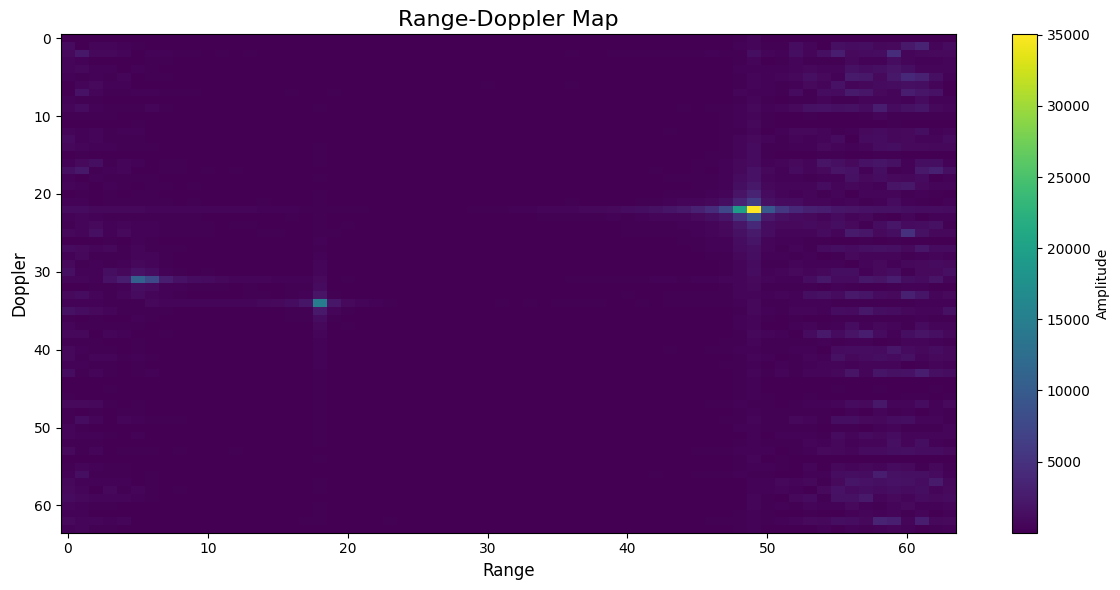

In [31]:
plt.figure(figsize=(12, 6))
plt.imshow(Z, aspect='auto', cmap='viridis')
plt.title("Range-Doppler Map", fontsize=16)
plt.xlabel("Range", fontsize=12)
plt.ylabel("Doppler", fontsize=12)
plt.colorbar(label="Amplitude")
plt.tight_layout()
plt.show()


In [ ]:
class CombinedRadarTester:
    def __init__(self, range_model: nn.Module, doppler_model: nn.Module, device: torch.device):
        """Initialize combined radar tester"""
        self.range_model = range_model.to(device)
        self.doppler_model = doppler_model.to(device)
        self.device = device
        self.R = generate_range_steering_matrix().to(device)
        self.V = generate_doppler_steering_matrix().to(device)

    def feed_forward(self, loader: DataLoader) -> tuple:
        """Run models once and get all predictions"""
        self.range_model.eval()
        self.doppler_model.eval()

        all_Y_r = []
        all_Y_v = []
        all_X_rv_proj = []
        all_Y_true = []

        with torch.no_grad():
            for _, _, X, _, RD, Y in loader:
                X = X.to(self.device)

                # Get range and Doppler predictions
                Y_r = self.range_model(X)
                Y_v = self.doppler_model(X)

                # Get range-Doppler projection
                # if needed
                X = X.to(torch.complex64)  # Convert X to a complex type if not already
                #print(X.shape)
                Z = torch.abs(self.R.H @ X @ self.V.conj())

                all_Y_r.append(Y_r)
                all_Y_v.append(Y_v)
                all_X_rv_proj.append(Z)
                all_Y_true.append(Y.to(self.device))

        # Concatenate all batches
        Y_r = torch.cat(all_Y_r, dim=0)
        Y_v = torch.cat(all_Y_v, dim=0)
        X_rv_proj = torch.cat(all_X_rv_proj, dim=0)
        Y_true = torch.cat(all_Y_true, dim=0)

        return Y_r, Y_v, X_rv_proj, Y_true

    @staticmethod
    def predict(Y_r: torch.Tensor, Y_v: torch.Tensor, X_rv_proj: torch.Tensor, threshold: float) -> torch.Tensor:
        """Apply threshold to predictions to get detections"""
        # Thresholding
        Y_r_binary = (Y_r > threshold).float()
        Y_v_binary = (Y_v > threshold).float()

        # Combine range and Doppler detections
        Y_rv = Y_r.unsqueeze(-1) @ Y_v.unsqueeze(-2)
        Y_rv_binary = Y_r_binary.unsqueeze(-1) @ Y_v_binary.unsqueeze(-2)

        # Final decision matrix
        ###X_rv_proj = abs(X_rv_proj.to(device))
        ###Y_rv       = Y_rv.to(device)
        ###Y_rv_binary= Y_rv_binary.to(device)

        #print(X_rv_proj.shape, Y_rv.shape, Y_rv_binary.shape)
        ###U = X_rv_proj[:, :, :63] * Y_rv * Y_rv_binary
        U = X_rv_proj * Y_rv * Y_rv_binary
        Y_hat = (U / U.max() > threshold).float()

        return Y_hat

    def get_metrics(self, Y_hat: torch.Tensor, Y_true: torch.Tensor) -> dict:
        """Evaluate detection performance for full dataset at once"""
        # Create the neighborhood kernel for 2D convolution
        kernel = torch.ones(1, 1, 3, 3, device=self.device)

        # Extend Y_hat and Y_true for convolution
        Y_hat_expanded = Y_hat.unsqueeze(1).float()  # [B, 1, H, W]
        Y_true_expanded = Y_true.unsqueeze(1).float()  # [B, 1, H, W]

        # Get extended matrices through convolution
        Y_true_extended = F.conv2d(Y_true_expanded, kernel, padding=1).squeeze(1)
        Y_true_extended = (Y_true_extended > 0)

        # Calculate PFA: Exclude target neighborhoods
        valid_cells = (~Y_true_extended).float()  # Cells not in target neighborhoods
        false_alarms = (Y_hat * valid_cells).sum()
        total_valid_cells = valid_cells.sum()
        Pfa = false_alarms.item() / total_valid_cells.item()

        # For PD: count targets and successful detections
        n_targets = Y_true.sum(dim=(1, 2))  # [B]

        # Get hits using extended Y_hat
        Y_hat_extended = F.conv2d(Y_hat_expanded, kernel, padding=1).squeeze(1)
        Y_hat_extended = (Y_hat_extended > 0).float()

        detected = (Y_hat_extended * Y_true).sum(dim=(1, 2))  # [B]

        # Calculate PD (if no targets, count as PD=1)
        Pd = torch.where(n_targets > 0, detected / n_targets, torch.ones_like(n_targets, dtype=torch.float32))
        Pd = Pd.mean().item()

        return {"Pd": Pd, "Pfa": Pfa}

    def find_threshold(self, loader: DataLoader, target_pfa: float) -> float:
        """Find threshold for target PFA using binary search"""
        # Get all predictions once
        Y_r, Y_v, X_rv_proj, Y_true = self.feed_forward(loader)

        th = 0.5  # Start at 0.5
        step = 0.5
        cnt = 1
        pfa_res = 1.0
        rel_err = abs(pfa_res - target_pfa) / abs(target_pfa)

        while rel_err >= 0.01 and cnt < 20:
            Y_hat = self.predict(Y_r, Y_v, X_rv_proj, th)
            metrics = self.get_metrics(Y_hat, Y_true)

            pfa_res = metrics["Pfa"]
            rel_err = abs(pfa_res - target_pfa) / abs(target_pfa)

            step = step * 0.5
            if pfa_res > target_pfa:
                th += step
            else:
                th -= step

            cnt += 1

        print(f"Found threshold = {th:.4f}, PFA = {pfa_res:.6f} after {cnt} iterations")
        return th

    def evaluate_pd_pfa(self, nu: float, scnr: float = 0) -> tuple:
        test_dataset_with_targets = RadarDataset(4096, n_targets=4, random_n_targets=False, nu=nu, scnr=scnr)
        test_dataset_no_targets = RadarDataset(2048, n_targets=0, random_n_targets=False, nu=nu, scnr=scnr)
        test_dataset = ConcatDataset([test_dataset_with_targets, test_dataset_no_targets])
        test_loader = DataLoader(test_dataset, batch_size=256, shuffle=True, num_workers=2,
                              pin_memory=torch.cuda.is_available(), persistent_workers=True)
        
        Y_r, Y_v, X_rv_proj, Y_true = self.feed_forward(test_loader)
        
        # Store results for different target PFAs
        results = []
        target_pFAs = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3]

        for target_pfa in tqdm(target_pFAs, desc="Testing PFAs"):
            # Use existing find_threshold method
            th = self.find_threshold(test_loader, target_pfa)
            Y_hat = self.predict(Y_r, Y_v, X_rv_proj, th)
            metrics = self.get_metrics(Y_hat, Y_true)
            results.append((metrics["Pd"], metrics["Pfa"]))
        
        pd_list, pfa_list = zip(*results)
        return np.array(pd_list), np.array(pfa_list)
        
    def evaluate_pd_scnr(self, nu: float, target_pfa: float = 5e-4) -> tuple:
        """Evaluate PD vs SCNR for fixed PFA"""
        # First find threshold using a reference dataset (SCNR = 0)
        ref_dataset_with_targets = RadarDataset(4096, n_targets=4, random_n_targets=False, nu=nu, scnr=0)
        ref_dataset_no_targets = RadarDataset(2048, n_targets=0, random_n_targets=False, nu=nu)
        ref_dataset = ConcatDataset([ref_dataset_with_targets, ref_dataset_no_targets])
        ref_loader = DataLoader(ref_dataset, batch_size=256, shuffle=True, num_workers=2,
                              pin_memory=torch.cuda.is_available(), persistent_workers=True)

        # Find threshold using binary search
        th = self.find_threshold(ref_loader, target_pfa)

        # Now evaluate for different SCNR values
        results = []
        scnr_range = np.arange(-30, 21, 5)

        for scnr in tqdm(scnr_range, desc="Testing SCNR values"):
            # Create dataset for this SCNR
            test_dataset_with_targets = RadarDataset(4096, n_targets=4, random_n_targets=False, nu=nu, scnr=scnr)
            test_dataset_no_targets = RadarDataset(2048, n_targets=0, random_n_targets=False, nu=nu, scnr=scnr)
            test_dataset = ConcatDataset([test_dataset_with_targets, test_dataset_no_targets])
            test_loader = DataLoader(test_dataset, batch_size=256, shuffle=True, num_workers=2,
                              pin_memory=torch.cuda.is_available(), persistent_workers=True)

            # Get predictions
            Y_r, Y_v, X_rv_proj, Y_true = self.feed_forward(test_loader)

            # Evaluate using found threshold
            Y_hat = self.predict(Y_r, Y_v, X_rv_proj, th)
            metrics = self.get_metrics(Y_hat, Y_true)

            results.append((metrics["Pd"], metrics["Pfa"]))

        pd_list, pfa_list = zip(*results)
        return np.array(pd_list), np.array(pfa_list), scnr_range



## Train & Evaluate DAFC

In [ ]:
# Create datasets with and without targets
train_dataset_with_targets = RadarDataset(num_samples=10240, n_targets=8, random_n_targets=True)
train_dataset_no_targets = RadarDataset(num_samples=10240, n_targets=0, random_n_targets=False)

val_dataset_with_targets = RadarDataset(num_samples=2048, n_targets=8, random_n_targets=True)
val_dataset_no_targets = RadarDataset(num_samples=2048, n_targets=0, random_n_targets=False)

# Combine datasets
train_dataset = ConcatDataset([train_dataset_with_targets, train_dataset_no_targets])
val_dataset = ConcatDataset([val_dataset_with_targets, val_dataset_no_targets])

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=2,
                            pin_memory=torch.cuda.is_available(), persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=True, num_workers=2,
                        pin_memory=torch.cuda.is_available(), persistent_workers=True)

NameError: name 'RadarDataset' is not defined

In [20]:
print("\nTraining IQ Range Detector:")
detection_type = "range"
ratio = calculate_ratio(train_loader, detection_type)
criterion = CBBCE(ratio)
range_model = DAFCRadarNet(detection_type)
range_history = train_model(range_model, criterion, train_loader, val_loader, detection_type)
plot_training_history(range_history, "Range")
detection_type = "doppler"
ratio = calculate_ratio(train_loader, detection_type)
criterion = CBBCE(ratio)
print("\nTraining IQ Doppler Detector:")
doppler_model = DAFCRadarNet(detection_type)
doppler_history = train_model(doppler_model, criterion, train_loader, val_loader, detection_type)
plot_training_history(doppler_history, "Doppler")


Training IQ Range Detector:
ratio: 0.0680908203125 , n1: 44624 , n_total: 655360
w1:  14.617713710872605
Last computed LR: 0.001


Training Progress:   0%|          | 1/300 [00:10<52:31, 10.54s/it]


Epoch 1/300
Train Loss: 0.8736 | Val Loss: 0.7052
Train Acc: 0.9119 | Val Acc: 0.8269


Training Progress:   2%|▏         | 7/300 [01:13<51:18, 10.51s/it]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using device: ", device)
range_model, doppler_model = load_trained_models()
tester = CombinedRadarTester(range_model, doppler_model, device)

# Test parameters
nu_values = [0.2, 0.5, 1.0]

# PD vs PFA test (SCNR = 0dB)
pd_pfa_results = {}
print("Running PD vs PFA test...")
for nu in tqdm(nu_values, desc="Testing clutter conditions"):
    pd, pfa = tester.evaluate_pd_pfa(nu, scnr=0)
    pd_pfa_results[nu] = (pd, pfa)
plot_pd_pfa(pd_pfa_results)

# PD vs SCNR test (PFA = 5e-4)
pd_scnr_results = {}
print("\nRunning PD vs SCNR test...")
for nu in tqdm(nu_values, desc="Testing clutter conditions"):
    pd, pfa, scnr = tester.evaluate_pd_scnr(nu)
    pd_scnr_results[nu] = (pd, pfa, scnr)
plot_pd_scnr(pd_scnr_results)